# Tonic sensitivity and expression variability of ISGs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read 1d HT result comparing to control

In [6]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [7]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200313.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [8]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

### Association between variability and tonic sensitivity

In [9]:
ctrl_var = all_result['ciliated']['moments']['beta']['3'][1][['gene', 'time_step_0']].rename(columns={'time_step_0':'ctrl_var'})

In [10]:
de_genes = all_result['ciliated']['ht']['beta']['3'].query('de_fdr < 0.05 & de_coef > 0').gene.tolist()

In [11]:
tonic_sensitivy_df = pd.read_csv('../tonic_isg.txt', sep='\t')
tonic_sensitivy_df['gene'] = tonic_sensitivy_df['GeneSymbol'].str.upper()
tonic_sensitivy_df = tonic_sensitivy_df[['gene', 'IFN.FC.WT']].rename(columns={'IFN.FC.WT':'tonic'})

In [12]:
df = ctrl_var.merge(tonic_sensitivy_df, on='gene')#.query('gene in @de_genes')

In [13]:
with open('hv_genes.pkl', 'rb') as f:
    hv_genes = pkl.load(f)

In [14]:
stats.pearsonr(df['ctrl_var'], df['tonic'])

(0.4662119615568761, 1.01600635665008e-06)

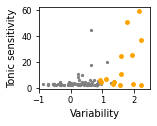

In [15]:
plt.figure(figsize=(2, 1.5))
plt.scatter(df['ctrl_var'], df['tonic'], color='grey', s=5)
plt.scatter(df.query('gene in @hv_genes')['ctrl_var'], df.query('gene in @hv_genes')['tonic'], color='orange', s=15)
plt.xlabel('Variability');plt.ylabel('Tonic sensitivity');
plt.xlim(-1, 2.5)
plt.savefig(fig_path + 'tonic_sensitivity.png', bbox_inches='tight', dpi=300)


In [19]:
df.sort_values('tonic').tail(10)

,gene,ctrl_var,tonic
4,GBP5,0.227188,10.98
98,USP18,0.647068,18.21
9,CMPK2,1.129880,20.08
97,MX1,1.570930,25.00
96,MX2,1.936787,25.96
51,IFIT2,2.847425,32.65
10,RSAD2,2.200770,37.39
29,CXCL10,0.635269,45.26
53,IFIT1,1.779004,51.14
52,IFIT3,2.152269,59.62
